In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.insert(0, 'code')

In [3]:
import json
from functools import reduce

import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch

from easydict import EasyDict as edict


from mac import MACNetwork
from utils import IntermediateLayerGetter, load_vocab
from datasets import GQADataset, collate_fn_gqa, ClevrDataset, collate_fn
from visualize_attentions2 import plot_word_img_attn_lobs, plot_word_img_attn_objs, idxs_to_question, get_image

In [6]:
model_dir = '/storage1/fcorencoret/FiLMac/data/1_256_3layers_faster/'

In [7]:
with open(os.path.join(model_dir, 'cfg.json'), 'r') as f:
    cfg = json.load(f)

In [8]:
from config import __C, _merge_a_into_b

cfg = edict(cfg)
_merge_a_into_b(cfg, __C)
cfg = __C

print(json.dumps(cfg.model, indent=4))

logcomet is not a valid config key
cfg_file is not a valid config key
exp_name is not a valid config key
manualSeed is not a valid config key
{
    "d_model": 256,
    "n_instructions": 1,
    "transformer_nlayers": 3,
    "transformer_dropout": 0.2,
    "transformer_heads": 4,
    "PE_dropout": 0.1,
    "n_filmblocks": 3,
    "in_channels": 2048,
    "cnn_dim": 256,
    "n_operations": 1,
    "operation_linear": false
}


In [9]:
data_dir = '/storage1/datasets/GQA/data'
cfg.DATASET.DATA_DIR = data_dir

dataset = cfg.DATASET.DATASET
cfg.DATASET.DATASET = dataset

# if dataset == 'clevr':
#     dataset_root = '/storage1/datasets/CLEVR_v1.0/'
# #     data_dir = os.path.join(dataset_root, 'data')
#     data_dir = os.path.join(dataset_root, 'features')
#     images_dir = os.path.join(dataset_root, 'images')
if dataset == 'gqa':
    dataset_root = '/storage1/datasets/GQA/'
    data_dir = os.path.join(dataset_root, 'data')
    images_dir = os.path.join(dataset_root, 'images')
    
cfg.DATASET.DATA_DIR = data_dir

In [10]:
split = 'val'
if cfg.DATASET.DATASET == 'gqa':
    ds = GQADataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(data_dir, f'balanced_{split}_data.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
        
elif cfg.DATASET.DATASET == 'clevr':
    ds = ClevrDataset(
        data_dir=cfg.DATASET.DATA_DIR,
        split=split,
    )
    with open(os.path.join(dataset_root, 'questions', f'CLEVR_{split}_questions.json'), 'r') as f:
        ds.questions = json.load(f)['questions']
    
vocab = load_vocab(cfg)
reverse_word_dic = vocab['question_token_to_idx']
reverse_answer_dic = vocab['answer_token_to_idx']
num_answers = len(reverse_answer_dic)

In [11]:
from filmant import load_filmant

In [13]:
model = load_filmant(vocab, cfg)
state = torch.load('/storage1/fcorencoret/FiLMac/data/1_256_3layers_faster/Model/model_checkpoint_000085.pth', map_location='cpu')
model.load_state_dict(state['model'])
model.eval()
return_layers = {
    'kb_attn_idty': 'kb_attn',
    'res_block_idty' : 'res_block_idty',
    'features_idty' : 'features_idty',
    'question_to_instruction.transformer.layers.0.self_attn' : 'cw_attn',
    'question_to_instruction.transformer.layers.1.self_attn' : 'cw_attn',
    'question_to_instruction.transformer.layers.2.self_attn' : 'cw_attn',
    'visualTransformer.layers.0.self_attn' : 'vis_attn',
    'visualTransformer.layers.1.self_attn' : 'vis_attn',
    'visualTransformer.layers.2.self_attn' : 'vis_attn',
    'reasoningTransformer.layers.0.self_attn' : 'res_attn',
    'reasoningTransformer.layers.1.self_attn' : 'res_attn',
    'reasoningTransformer.layers.2.self_attn' : 'res_attn',

}
mid_getter = IntermediateLayerGetter(model, return_layers, keep_output=True)

num_steps = cfg.model.n_instructions

In [14]:
import pandas as pd
import seaborn as sns
from visualize_attentions import plot_word_img_attn, plot_languaje_attn

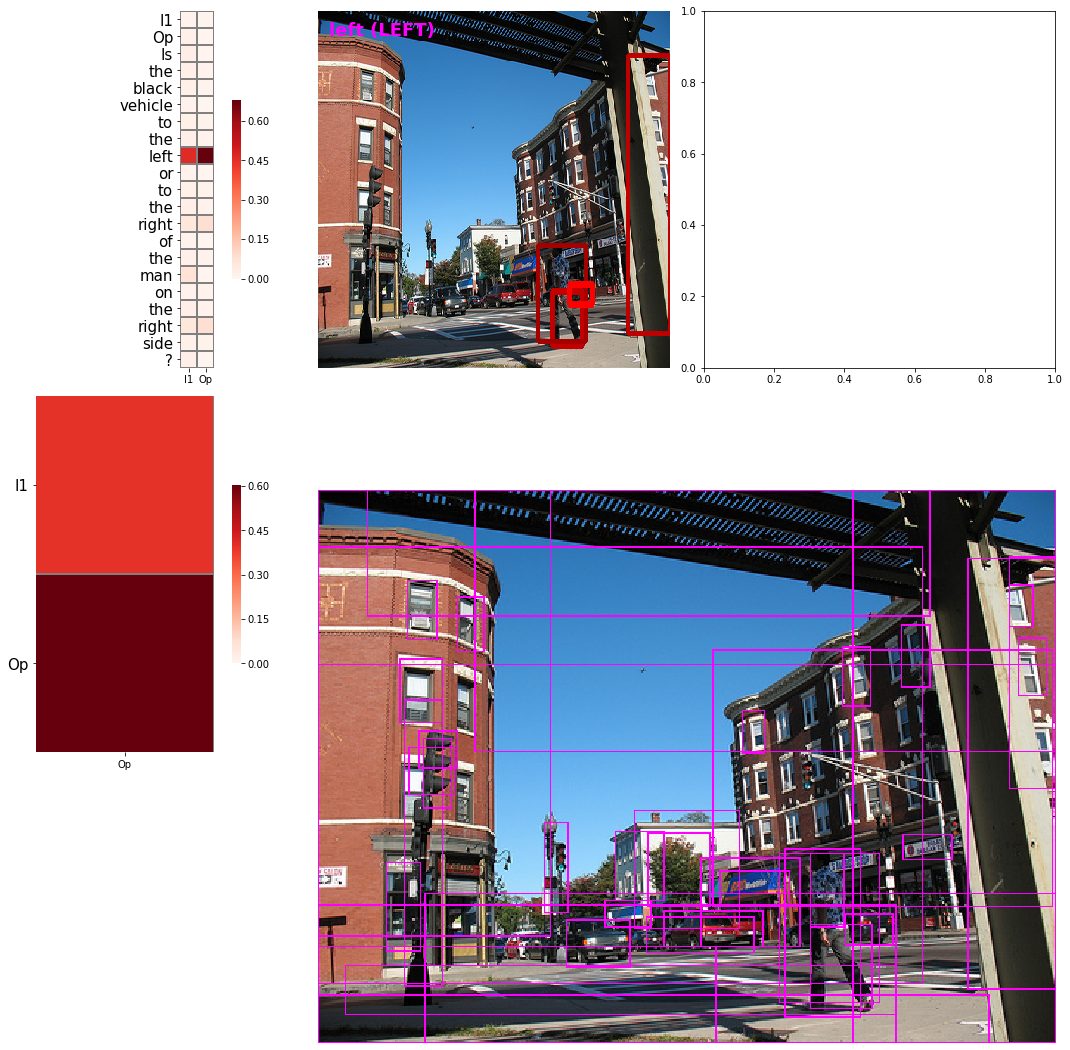

In [29]:
q_index = 5312
stack = -1

if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    
    imgid, question, answer, group, questionid = ds.data[q_index]
    img_info = ds.spatial_info[imgid]
    num_gt_objs = img_info['objectsNum']
    
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['question'].cuda(), b['question_length'], b['image'].cuda(), b['bbox'].cuda())

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['bbox'][0].numpy()
# num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

# reduction = avg_transformer_layers_outputs
reduction = reduce_transformer_attn

# cw_attns = reduction(mid_outputs['cw_attn'])
cw_attns = [attn[1][0] for attn in mid_outputs['cw_attn']][stack]
vis_attns = reduction(mid_outputs['vis_attn'])
# obj_vis_attns = vis_attns[-cfg.model.n_instructions:,:num_gt_objs]
obj_vis_attns = [attn[1][0] for attn in mid_outputs['vis_attn']][stack][-cfg.model.n_instructions:,:num_gt_objs]
op_attns = reduction(mid_outputs['res_attn'])
# op_attns = op_attns[-1:]
op_attns = [attn[1][0] for attn in mid_outputs['res_attn']][stack][-1:]

plot_word_img_attn(
    cw_attns=cw_attns,
    bboxes=bboxes,
    obj_vis_attns=obj_vis_attns,
    op_attns=op_attns,
    num_steps=num_steps,
    words=tokenized_questions,
    images_root=images_dir,
    image_filename=image_filename,
    pred=pred,
    gt=gt,
    model_cfg=cfg.model,
#     vis='attn',
    num_gt_objs=num_gt_objs,
)

In [38]:
len(cw_attns), len(obj_vis_attns[0][0]), len(op_attns[0][0])

(3, 43, 2)

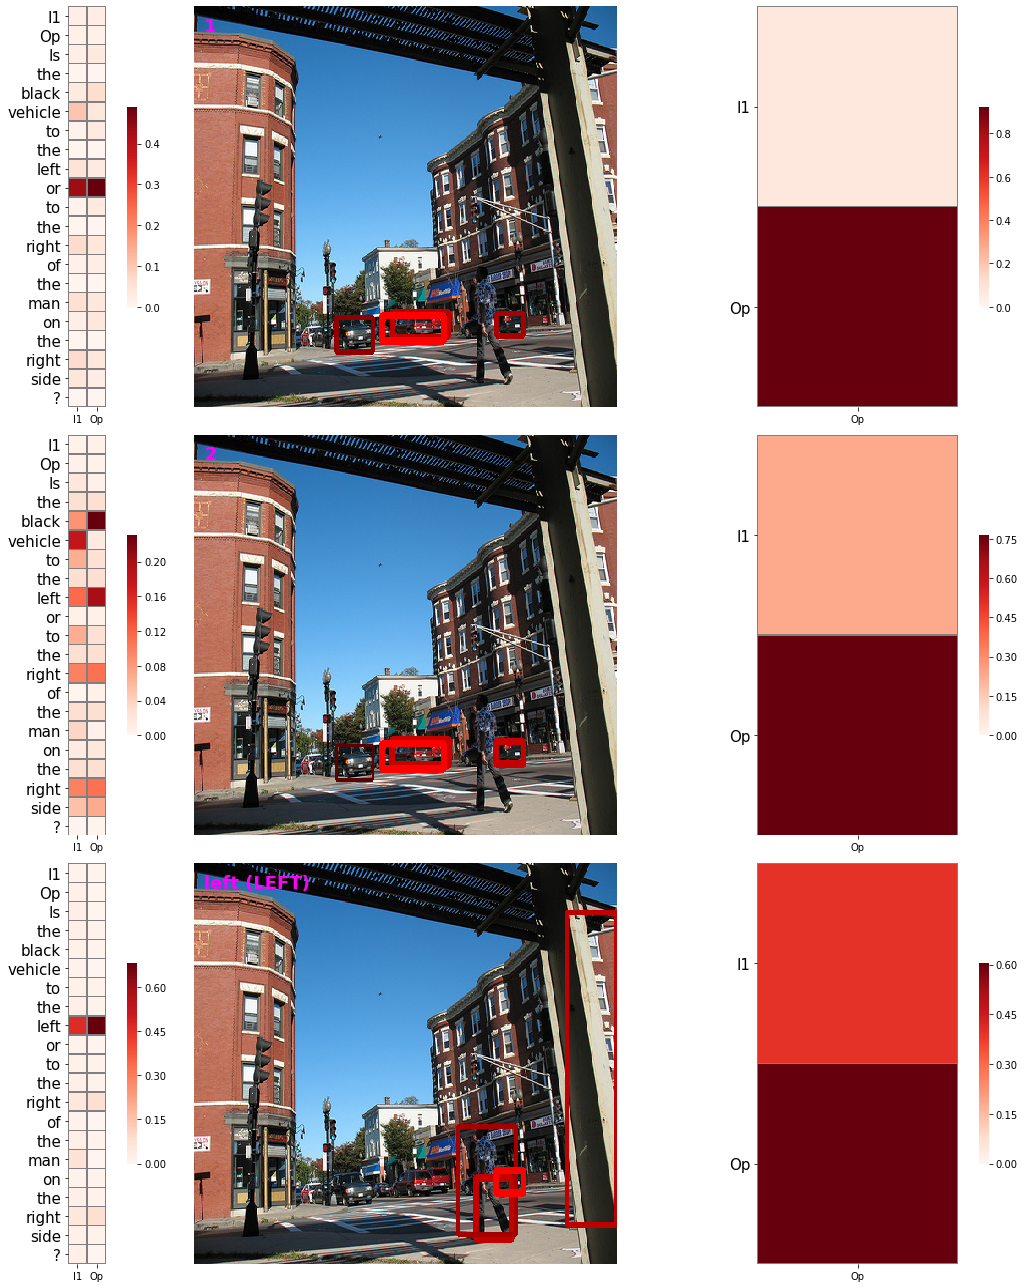

In [56]:
q_index = 5312
if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    
    imgid, question, answer, group, questionid = ds.data[q_index]
    img_info = ds.spatial_info[imgid]
    num_gt_objs = img_info['objectsNum']
    
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['question'].cuda(), b['question_length'], b['image'].cuda(), b['bbox'].cuda())

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['bbox'][0].numpy()
# num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

# reduction = avg_transformer_layers_outputs
reduction = reduce_transformer_attn

cw_attns = [attn[1][0] for attn in mid_outputs['cw_attn']]
# vis_attns = reduction(mid_outputs['vis_attn'])
# obj_vis_attns = vis_attns[-cfg.model.n_instructions:,:num_gt_objs]
obj_vis_attns = [attn[1][0] for attn in mid_outputs['vis_attn']]
obj_vis_attns = [obj[-cfg.model.n_instructions:,:num_gt_objs][0] for obj in obj_vis_attns]
# op_attns = op_attns[-1:]
op_attns = [attn[1][0] for attn in mid_outputs['res_attn']]
op_attns = [op[-1:][0] for op in op_attns]


plot_languaje_attn(
    cw_attns=cw_attns,
    bboxes=bboxes,
    obj_vis_attns=obj_vis_attns,
    op_attns=op_attns,
    num_steps=num_steps,
    words=tokenized_questions,
    images_root=images_dir,
    image_filename=image_filename,
    pred=pred,
    gt=gt,
    model_cfg=cfg.model,
#     vis='attn',
    num_gt_objs=num_gt_objs,
)

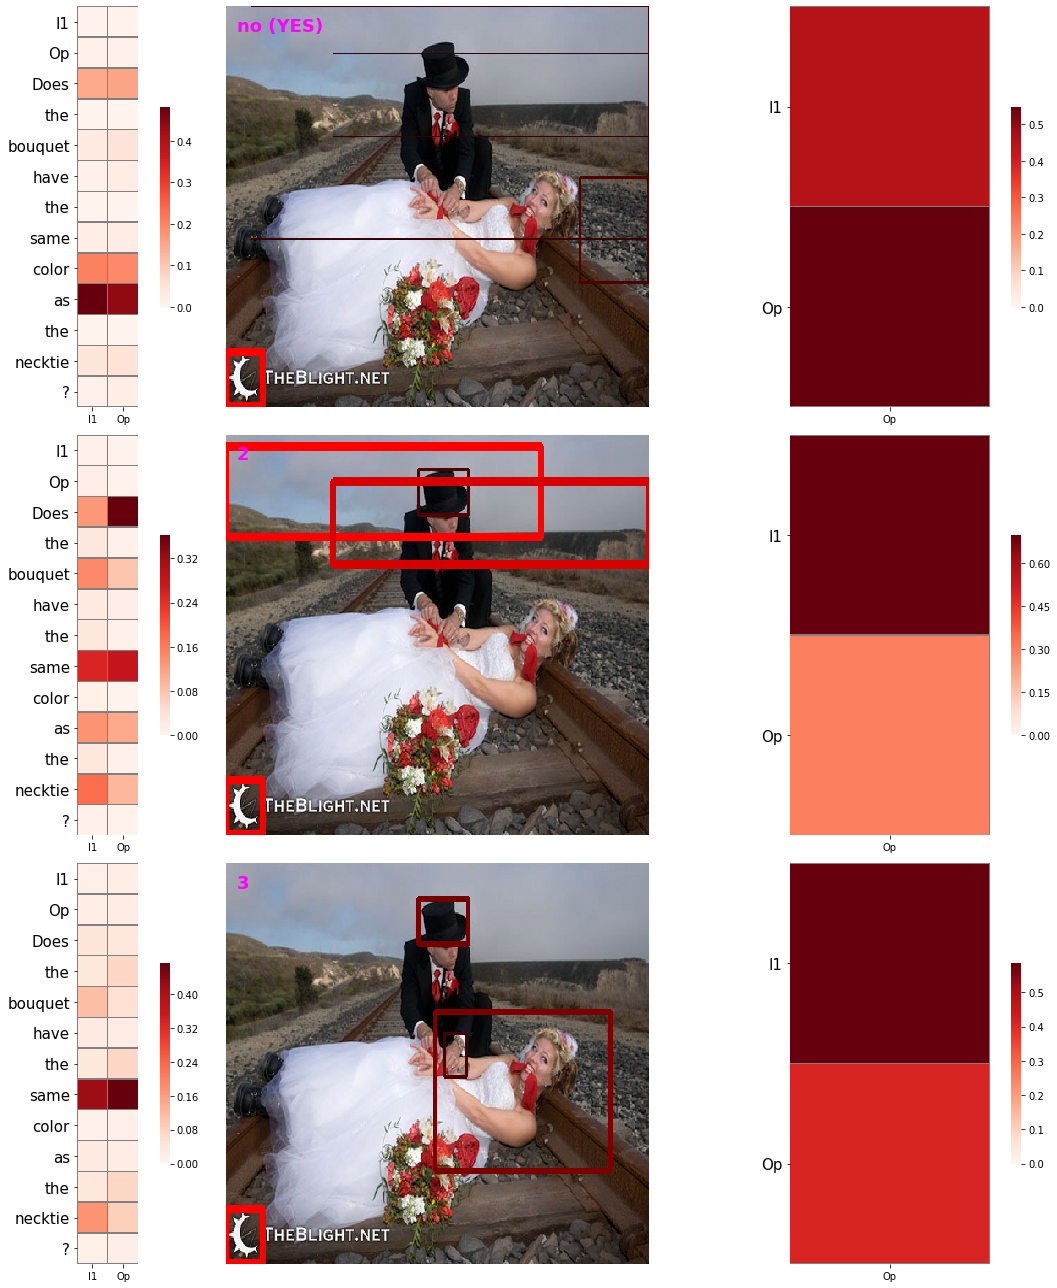

In [45]:
q_index = 1299
if dataset == 'gqa':
    b = collate_fn_gqa([ds[q_index]])
    image_filename = ds.questions[q_index]['imageId'] + '.jpg'
    
    imgid, question, answer, group, questionid = ds.data[q_index]
    img_info = ds.spatial_info[imgid]
    num_gt_objs = img_info['objectsNum']
    
elif dataset == 'clevr':
    b = collate_fn([ds[q_index]])
    image_filename = os.path.join(split, ds.questions[q_index]['image_filename'])
    
with torch.no_grad():
    mid_outputs, output = mid_getter(b['question'].cuda(), b['question_length'], b['image'].cuda(), b['bbox'].cuda())

pred = vocab['answer_idx_to_token'][output.argmax().item()]
gt = vocab['answer_idx_to_token'][b['answer'].item()]
bboxes = b['bbox'][0].numpy()
# num_gt_objs = b['image'][1].item()

tokenized_questions = idxs_to_question(b['question'][0].numpy(), vocab['question_idx_to_token'])

# reduction = avg_transformer_layers_outputs
reduction = reduce_transformer_attn

cw_attns = [attn[1][0] for attn in mid_outputs['cw_attn']]
# vis_attns = reduction(mid_outputs['vis_attn'])
# obj_vis_attns = vis_attns[-cfg.model.n_instructions:,:num_gt_objs]
obj_vis_attns = [attn[1][0] for attn in mid_outputs['vis_attn']]
obj_vis_attns = [obj[-cfg.model.n_instructions:,:num_gt_objs][0] for obj in obj_vis_attns]
# op_attns = op_attns[-1:]
op_attns = [attn[1][0] for attn in mid_outputs['res_attn']]
op_attns = [op[-1:][0] for op in op_attns]


plot_languaje_attn(
    cw_attns=cw_attns,
    bboxes=bboxes,
    obj_vis_attns=obj_vis_attns,
    op_attns=op_attns,
    num_steps=num_steps,
    words=tokenized_questions,
    images_root=images_dir,
    image_filename=image_filename,
    pred=pred,
    gt=gt,
    model_cfg=cfg.model,
#     vis='attn',
    num_gt_objs=num_gt_objs,
)

In [17]:
def interpolate(val, x_low, x_high):
    return (val - x_low) / (x_high - x_low)

In [18]:
def reduce_transformer_attn(attn_outputs):
    attns = [attn[1][0] for attn in attn_outputs]
    
    return reduce(lambda x, y: torch.matmul(x, y), attns)

In [19]:
def avg_transformer_layers_outputs(attn_outputs):
    attns = [attn[1][0] for attn in attn_outputs]
    attns = sum(attns) / len(attns)
    
    return attns

In [46]:
lxrt = torch.load('/storage1/fcorencoret/FiLMac/model_LXRT.pth')

In [47]:
for key, value in lxrt.items():
    print(key)

module.bert.embeddings.word_embeddings.weight
module.bert.embeddings.position_embeddings.weight
module.bert.embeddings.token_type_embeddings.weight
module.bert.embeddings.LayerNorm.weight
module.bert.embeddings.LayerNorm.bias
module.bert.encoder.visn_fc.visn_layer_norm.weight
module.bert.encoder.visn_fc.visn_layer_norm.bias
module.bert.encoder.visn_fc.box_layer_norm.weight
module.bert.encoder.visn_fc.box_layer_norm.bias
module.bert.encoder.layer.0.attention.self.query.weight
module.bert.encoder.layer.0.attention.self.query.bias
module.bert.encoder.layer.0.attention.self.key.weight
module.bert.encoder.layer.0.attention.self.key.bias
module.bert.encoder.layer.0.attention.self.value.weight
module.bert.encoder.layer.0.attention.self.value.bias
module.bert.encoder.layer.0.attention.output.dense.weight
module.bert.encoder.layer.0.attention.output.dense.bias
module.bert.encoder.layer.0.attention.output.LayerNorm.weight
module.bert.encoder.layer.0.attention.output.LayerNorm.bias
module.bert.en

In [48]:
for key, value in state['model'].items():
    print(key)

question_to_instruction.transformer.layers.0.self_attn.in_proj_weight
question_to_instruction.transformer.layers.0.self_attn.in_proj_bias
question_to_instruction.transformer.layers.0.self_attn.out_proj.weight
question_to_instruction.transformer.layers.0.self_attn.out_proj.bias
question_to_instruction.transformer.layers.0.linear1.weight
question_to_instruction.transformer.layers.0.linear1.bias
question_to_instruction.transformer.layers.0.linear2.weight
question_to_instruction.transformer.layers.0.linear2.bias
question_to_instruction.transformer.layers.0.norm1.weight
question_to_instruction.transformer.layers.0.norm1.bias
question_to_instruction.transformer.layers.0.norm2.weight
question_to_instruction.transformer.layers.0.norm2.bias
question_to_instruction.transformer.layers.1.self_attn.in_proj_weight
question_to_instruction.transformer.layers.1.self_attn.in_proj_bias
question_to_instruction.transformer.layers.1.self_attn.out_proj.weight
question_to_instruction.transformer.layers.1.self

In [49]:
state['model']['question_to_instruction.transformer.layers.0.self_attn.in_proj_weight'].shape

torch.Size([768, 256])

In [50]:
lxrt['module.bert.encoder.layer.0.attention.self.query.weight'].shape

torch.Size([768, 768])